In [1]:
# from torch_pgd import pgd_attack
from utils import get_pretrained_model

import torch as ch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

import os, random

In [2]:
def tensor2pic(ImA, pop_img=False, save=False, name="pil_image.png", verbose=False):
    ImA = ImA[0].numpy()
    ImA = ImA.transpose(1, 2, 0)
    img = Image.fromarray(np.uint8(ImA * 255), 'RGB')
    if save:
        if verbose:
            print("Storing image:", name)
        img.save(name)
    if pop_img:
        img.show()
    else:
        return img

In [3]:
# The standard norm params
mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]
normalize = transforms.Normalize(mean = mean,
                      std = std)

class UnNormalize(object):
    # https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
unNormalize = UnNormalize(mean, std)

In [4]:
imA = Image.open("doge.jpg")
imA = imA.convert("RGB")
img_tA = transforms.ToTensor()(imA).view(1, 3, 224, 224)

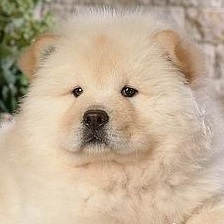

In [5]:
tensor2pic(img_tA)

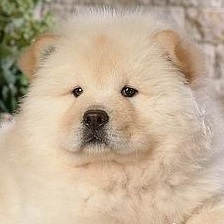

In [6]:
tmp = normalize(img_tA[0]).view(1, 3, 224, 224)
tensor2pic(img_tA)

In [8]:
import torch as ch
from torch.autograd import Variable
import torch.nn as nn


def pgd_attack(img, eps, model, steps=5, step_size=.1, targeted_attack=False, target_class=0, norm='l2',
               verbose=True):
    # Based on the tutorial: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
    """
    img:   should have shape (1, 3, imgsize, imgsize)
    model: the pretrained model WITHOUT softmax layer at end
    """
    img.requires_grad = True
    out = model(img)

    if targeted_attack:
        sign_direction = -1
    else:
        # Use predicted class as "anti-target" to minimize
        _, temp_target = ch.max(out, 1)
        target_class = temp_target[0]
        sign_direction = 1

    if verbose:
        print("Target_before", out[0, target_class])

    # Creates target class that the loss function accepts
    target = ch.FloatTensor(out.shape).zero_()
    target[0, target_class] = 1.
    _, targets = target.max(dim=1)

    # The attack
    pert_img = img
    for _ in range(steps):
        pert_img = Variable(normalize(pert_img[0]).view(1, 3, 224, 224))
        pert_img.requires_grad = True

        output = model(pert_img)
        loss = nn.CrossEntropyLoss()(output, Variable(targets))

        model.zero_grad()
        loss.backward()
        grad = pert_img.grad.data

        # Fast gradient sign method
        pert_img = pert_img + sign_direction * step_size * grad.sign()

        # Making sure pert image is inside l-2 or l-ing ball
        diff = pert_img - img
        if (norm == 'l2'):
            diff = ch.renorm(diff, 2, 0, eps)
        else:
            diff = ch.clamp(diff, -eps, eps)
        pert_img = img + diff
        
        pert_img = unNormalize(pert_img[0]).view(1, 3, 224, 224)
        pert_img = Variable(ch.clamp(pert_img, 0, 1))

    out = model(pert_img)

    if verbose:
        print("Output after:", ch.max(out, 1))
        print("Target after", out[0, target_class])

    return pert_img


In [9]:
# Storage details
save_images = True
title = "1_"
save_path = 'Results/trans/'
images = []

In [10]:
# Parameters
eps = 60
steps = 80
step_size = 0.5
targeted_attack = True
norm = 'l2'
verbose = False

In [11]:
# Models and datasets
dataset_path = 'datasets/'
model_name = 'RestrictedImageNet'

In [12]:
def max_all_classes(model_name, image_tensor, title, save=True):
    # Iterates over all classes in the restricted imagenet 
    # and maximizes their class score for an image
    
    images = [image_tensor.detach()]
    
    tensor2pic(image_tensor.detach(), save=True, name=save_path+title+"orig.png", verbose=verbose)
    
        
    _, model = get_pretrained_model(model_name)
    model.eval()
    
    for i in range(9):
        out_img = pgd_attack(image_tensor, eps=eps, model=model, steps=steps, step_size=step_size, 
                            targeted_attack=targeted_attack, target_class=i, 
                            norm=norm, verbose=verbose)
        
        images.append(out_img)
    
        tensor2pic(out_img, save=True, name=save_path+title+"to"+str(i)+".png", verbose=verbose)
    
    return images

In [13]:
l = max_all_classes(model_name, img_tA, title+"uno_")

In [ ]:
tensor2pic(l[0])

In [1]:
tensor2pic(l[1])

NameError: name 'tensor2pic' is not defined

In [ ]:
tensor2pic(l[2])

In [ ]:
tensor2pic(l[3])

In [ ]:
tensor2pic(l[4])

In [ ]:
tensor2pic(l[5])

In [ ]:
tensor2pic(l[6])

In [2]:
tensor2pic(l[7])

NameError: name 'tensor2pic' is not defined

In [ ]:
tensor2pic(l[8])

In [3]:
tensor2pic(l[9])

NameError: name 'tensor2pic' is not defined